# Lab 4: Building a Spotify Song Classifier with KNNs and Decision Trees
**Classify by genres**. In this lab, you will build machine learning genre classifiers using a dataset of Spotify tracks. Your goal is to train a model that can distinguish between two selected genres based on various audio features such as danceability, energy, valence, tempo, and more.

We'll follow the familiar workflow of data exploration -> preprocessing -> model training -> evaluation

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

### Step 1: The data
We'll focus on two genres: Blues and Jazz (what’s the difference, anyway??).

Both genres have rich musical histories, but they differ in structure:

- Blues tends to have simpler chord progressions and a strong emotional expression.
- Jazz often involves complex improvisation and more varied rhythms.

But can a machine really tell them apart just by looking at numerical audio features? That’s what we’ll find out!

In this step, you will:
- Load the dataset
- Extract only blues and jazz for classification

In [2]:
spotify_data = pd.read_csv('/courses/EDS232/Data/spotify_dat.csv')

# Print the data types in spotify_data
print(spotify_data.info())
#print(spotify_data.head())
# Filter down to two genres
blues_data = spotify_data[spotify_data['genres'].str.contains("blues", na=False)]
jazz_data =  spotify_data[spotify_data['genres'].str.contains("jazz", na=False)]

# Combine both genres into one dataset
combined_data = pd.concat([blues_data, jazz_data])#.reset_index(drop=True)

# Rename 'genres' column to 'genre' for clarity
combined_data = combined_data.rename(columns={'genres':'genre'})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204025 entries, 0 to 1204024
Data columns (total 25 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1204025 non-null  object 
 1   name              1204022 non-null  object 
 2   album             1204014 non-null  object 
 3   album_id          1204025 non-null  object 
 4   artists           1204025 non-null  object 
 5   artist_ids        1204025 non-null  object 
 6   track_number      1204025 non-null  int64  
 7   disc_number       1204025 non-null  int64  
 8   explicit          1204025 non-null  bool   
 9   danceability      1204025 non-null  float64
 10  energy            1204025 non-null  float64
 11  key               1204025 non-null  int64  
 12  loudness          1204025 non-null  float64
 13  mode              1204025 non-null  int64  
 14  speechiness       1204025 non-null  float64
 15  acousticness      1204025 non-null  float64
 16  

## Step 2: Data Exploration
Now that we have Blues and Jazz as our two genres, it's time to explore the data and look for patterns in the audio features.

Let's investigate:
- Which features are available?
- How strongly these features correlate with each other.
- How different genres distribute across  sample features: danceability 

In this step, we will:
- Filter out non-numeric columns before the plotting
- Visualize feature correlations using a heatmap.
- Examine key feature distributions with histograms to see if genres behave differently.


<Axes: >

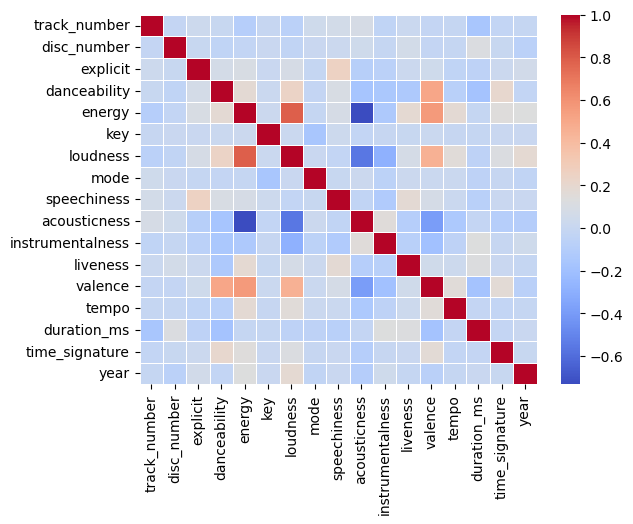

In [3]:
# Exclude non-numeric columns but keep 'genre' for grouping
numeric_features = combined_data.select_dtypes(include=['int64','bool', 'float64'])
numeric_features['genre'] = combined_data['genre']

#Correlation heatmap
cm = numeric_features.drop(columns=['genre']).corr()
sns.heatmap(cm, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)

Figure 1: Correlation matrix showing pairwise relationships between 17 musical attributes extracted from a song dataset. The color scale ranges from dark blue (-1.0) to dark red (1.0), representing negative to positive correlations respectively. Notable strong positive correlations exist between energy and loudness (0.7), while acousticness shows strong negative correlations with energy (-0.7). Most temporal features (duration, time signature, year) display weak correlations with other musical characteristics, suggesting their relative independence. The diagonal elements show perfect self-correlations (1.0) as expected in a correlation matrix.

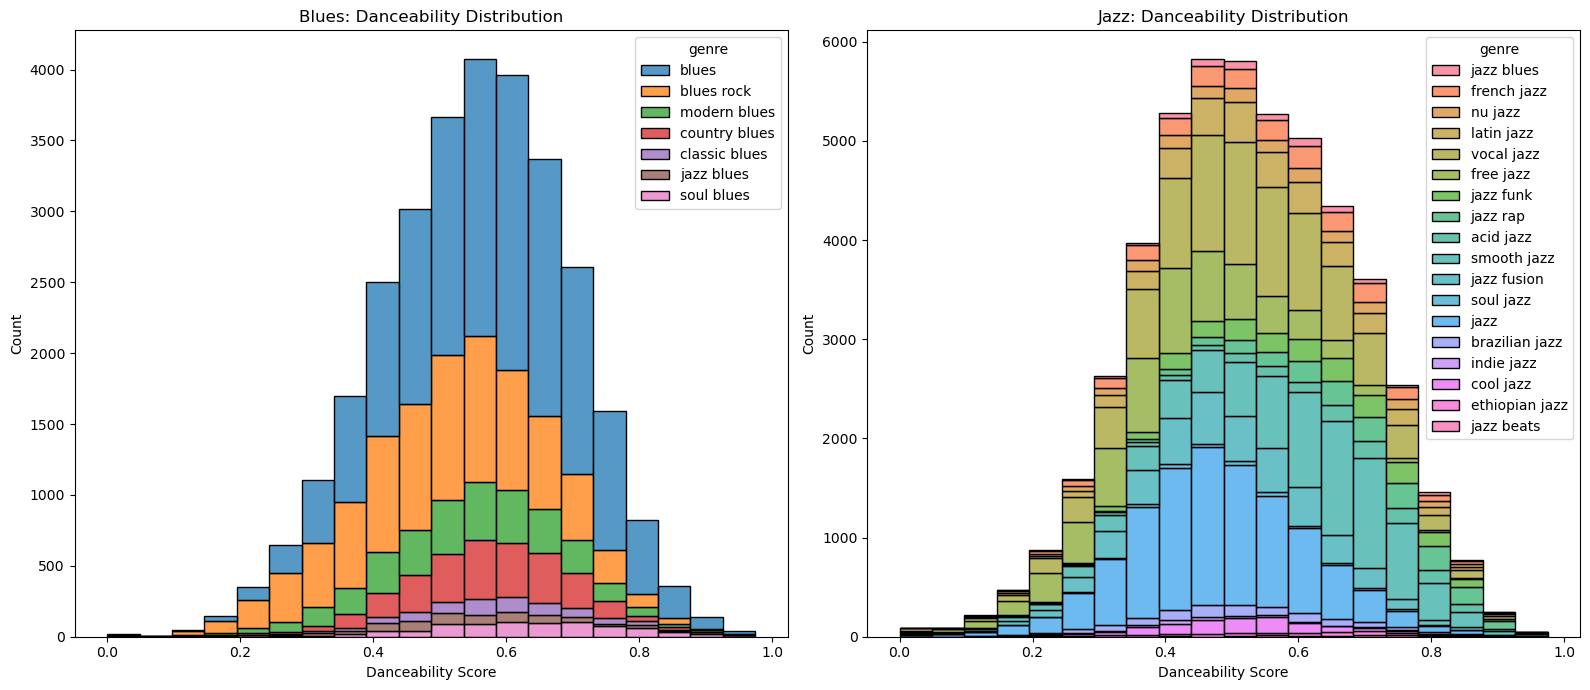

In [4]:
# Histogram of danceability
plt.figure(figsize=(16, 7))

# First subplot for blues
plt.subplot(1, 2, 1)
sns.histplot(data=numeric_features[numeric_features['genre'].str.contains('blues')], 
             x='danceability', multiple="stack", bins=20, hue='genre')
plt.xlabel('Danceability Score')
plt.ylabel('Count')
plt.title('Blues: Danceability Distribution')

# Second subplot for jazz
plt.subplot(1, 2, 2)
ax = sns.histplot(data=numeric_features[numeric_features['genre'].str.contains('jazz')], 
             x='danceability', bins=20, multiple="stack", hue='genre')
sns.move_legend(ax, 'upper right')
plt.xlabel('Danceability Score')
plt.ylabel('Count')
plt.title('Jazz: Danceability Distribution')
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Figure 2: Distribution of danceability scores comparing blues (left) and jazz (right) genres. Both genres display approximately normal distributions with peaks centered around danceability scores of 0.5-0.6. The jazz genre shows a higher total count of songs and slightly more spread in its distribution compared to blues. Danceability scores range from 0 to 1, where higher values indicate greater suitability for dancing.

### Step 3: Check for class imbalance
An unequal distribution between the target classes can cause issues for our classifiers, so we'll need to check for that. A commonly used guideline for class imbalance is:

- Slight Imbalance (Less than 1.5:1) → Generally okay; no need for balancing.
- Moderate Imbalance (Between 1.5:1 and 3:1) → Might cause some bias; balancing can help.
- Severe Imbalance (More than 3:1) → Strongly affects model performance; balancing is usually necessary.

In [5]:
# Print counts of each genre
class_counts_blues = len(numeric_features[numeric_features['genre'].str.contains('blues')])
class_counts_jazz = len(numeric_features[numeric_features['genre'].str.contains('jazz')])
print(f"Number of songs (class counts) by genre:\nBlues: {class_counts_blues:,} songs\nJazz: {class_counts_jazz:,} songs")
# Calculate ratio of majority to minority class
class_ratio = class_counts_jazz/class_counts_blues

# Print class distribution and ratio
print(f"Class Ratio (Jazz/Blues): {class_ratio:.2f}")


Number of songs (class counts) by genre:
Blues: 30,173 songs
Jazz: 50,138 songs
Class Ratio (Jazz/Blues): 1.66


Given this result, should we be worried about the imbalance?

Since the class ratio (1.66:1) shows a moderate imbalance between jazz and blues songs in our dataset, applying class balancing techniques could improve our analysis results.

### Step 4: Preprocessing
We need to ensure all the variables we use are numerical so the models can process them. First we'll drop all the variables that are not numeric or the target. Then we'll use a sklearn utility, `LabelEncoder()` to encode our categorical target variable into numerical values. Print the first five values of your encoded labels.

In [6]:
# Define the features (drop columns that are not numeric or target)
X = combined_data.select_dtypes(include=['int64','bool', 'float64'])

# Set the target variable as 'genre'
y = combined_data['genre'] 

# Encode the target variable ('label') using label encoding
label_encoder = LabelEncoder()
label_encoder.fit(y)
y_encoded = label_encoder.transform(y)

# Print first five values of encoded labels
print(y_encoded[:5])

[1 1 1 1 1]


Good, now we'll do our data splitting and scaling.  Let's go with an 80/20 split this time.

In [7]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler() 

# Fit and transform only the training set
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test set
X_test_scaled = scaler.transform(X_test)


### Step 5: Train the models
OK, now it's time to build our models and assess the training accuracy. We'll use the default of k = 5 for the KNN model.

In [8]:
# Initialize models
knn = KNeighborsClassifier(n_neighbors=5)
dt = DecisionTreeClassifier() # max depth TBD

# Train (fit) both models
knn.fit(X_train_scaled, y_train)
dt.fit(X_train_scaled, y_train)

# Predictions on training data
knn_y_train_pred = knn.predict(X_train_scaled)
dt_y_train_pred = dt.predict(X_train_scaled)

# Compute training accuracy
knn_train_accuracy = accuracy_score(y_train, knn_y_train_pred)
dt_train_accuracy = accuracy_score(y_train, dt_y_train_pred)

#Print training accuracy for both models
print(f"Training accuracy in KNN model: {knn_train_accuracy: .4f}; \nTraining accuracy in DT model: {dt_train_accuracy: .4f}")

Training accuracy in KNN model:  0.5464; 
Training accuracy in DT model:  1.0000


### Step 6: Evaluate models
OK, now let's go ahead and predict on the test data to see how well our models do at predicting the genre of unseen tracks.

In [9]:
# Make predictions
knn_pred = knn.predict(X_test_scaled)
dt_pred = dt.predict(X_test_scaled)

# Evaluate prediction accuracy
knn_accuracy = accuracy_score(y_test, knn_pred)
dt_accuracy = accuracy_score(y_test, dt_pred)

#Print prediction accuracy for both models
print(f"Prediction accuracy in KNN model: {knn_accuracy: .4f} \nPrediction accuracy in DT model: {dt_accuracy: .4f}")

Prediction accuracy in KNN model:  0.3708 
Prediction accuracy in DT model:  0.3223


### Step 7: Visualizing Model Performance
Now that we have evaluated our models on unseen data, let’s compare their performance by visualizing the training vs. test accuracy.  We'll look for signs of overfitting by plotting the training accuracy and test accuracy for both k-NN and Decision Trees.

Create a bar chart that compares the training accuracy and test accuracy for k-NN and Decision Trees. Your plot should clearly display:

- The training and test accuracy for both models.
- Properly labeled axes and a title.
- A legend to differentiate training and test accuracy.
- Accuracy values displayed on top of each bar.

Text(0.5, 1.0, 'Model Performance Comparison: Training vs Test Accuracy')

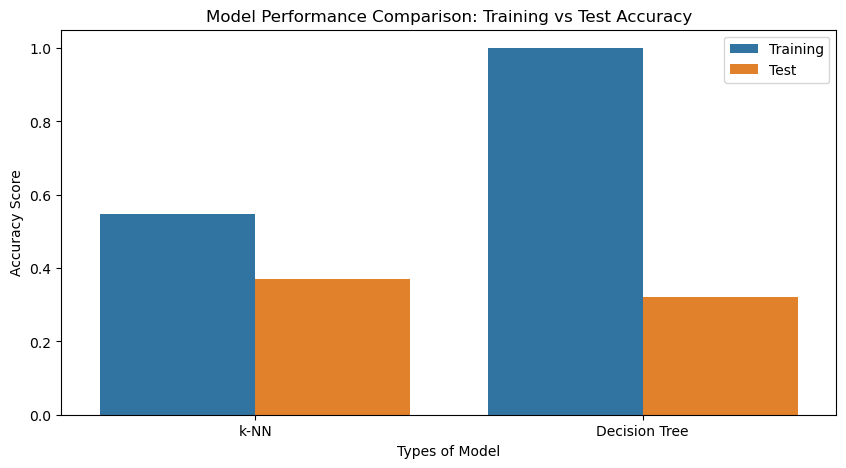

In [10]:
plt.figure(figsize=(10,5))

#sns.barplot(data=, x=, bins=20, hue='')
sns.barplot(x=['k-NN', 'k-NN', 'Decision Tree', 'Decision Tree'],
            y=[knn_train_accuracy, knn_accuracy, dt_train_accuracy, dt_accuracy],
            hue=['Training', 'Test', 'Training', 'Test'])
plt.xlabel('Types of Model')
plt.ylabel('Accuracy Score')
plt.title('Model Performance Comparison: Training vs Test Accuracy')


Which model does a better job of generalizing to unseen data? How do you know?
Does it appear that either of the models are overfitting? Why?

*The k-Nearest Neighbors (k-NN) model performs better on unseen data, with a slightly higher test accuracy score of 0.37. On the other hand, the Decision Tree model seems to overfit, likely because no max-depth was set during initialization. This is reflected in its perfect training accuracy of 1, which is much higher than its test accuracy.*

### Bonus question
In the workflow above, we used the default parameter values of k = 5 for the KNN model, and maxdepth = None for the Decision Tree. Choose one of the models and see if you can improve test performance by optmizing its corresponding parameter value.

### Tune a KNN Model and Visualize results

K = 1 - Accuracy:  0.322
K = 2 - Accuracy:  0.311
K = 3 - Accuracy:  0.344
K = 4 - Accuracy:  0.359
K = 5 - Accuracy:  0.371
K = 6 - Accuracy:  0.376
K = 7 - Accuracy:  0.385
K = 8 - Accuracy:  0.391
K = 9 - Accuracy:  0.396
K = 10 - Accuracy:  0.399
K = 11 - Accuracy:  0.403
K = 12 - Accuracy:  0.405
K = 13 - Accuracy:  0.408
K = 14 - Accuracy:  0.408
K = 15 - Accuracy:  0.410


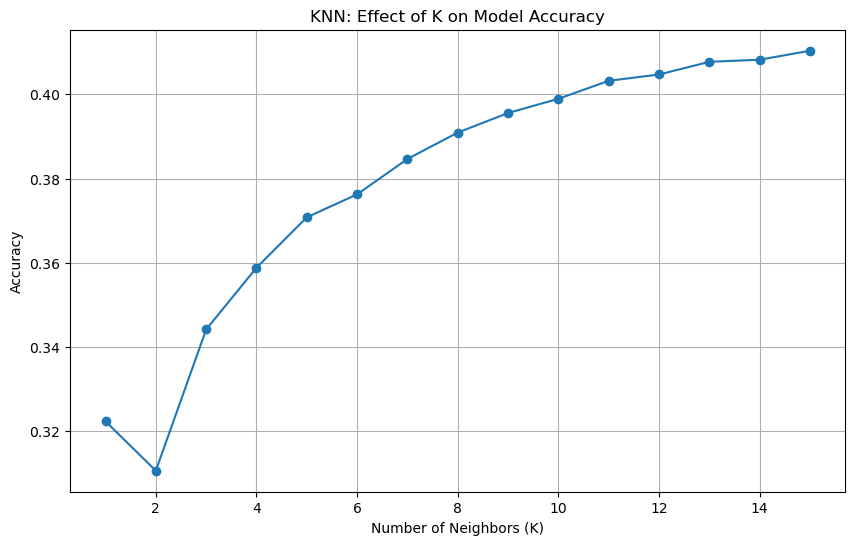

In [11]:
# Write a function to test on differen k value
def knn():
    k_values = list(range(1, 16))
    accuracies = []
    # Loop through different k values and fit a model/obtain accuracy
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train_scaled, y_train)
        
        # Make predictions and calculate accuracy
        y_pred = knn.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        
        print(f"K = {k} - Accuracy: {accuracy: .3f}")
    
    # Visualize the effect of K on accuracy
    plt.figure(figsize = (10, 6))
    plt.plot(k_values, accuracies, marker = 'o')
    plt.xlabel('Number of Neighbors (K)')
    plt.ylabel('Accuracy')
    plt.title('KNN: Effect of K on Model Accuracy')
    plt.grid(True)
    plt.show()
knn()

### Tune a decision tree model and visualize results

In [16]:
def decision_tree():
    # different possible mas depths
    max_depths = [2,3,4,5]
    accuracies = []

    # Loop through different max depths and run a DT model/ report accuracies    
    for depth in max_depths:
        dt = DecisionTreeClassifier(max_depth = depth)
        dt.fit(X_train_scaled, y_train)
        y_pred = dt.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        
        print(f"Max Depth: {depth} - Accuracy: {accuracy:.3f}")
    # Visualize the effect of K on accuracy
    plt.figure(figsize = (10, 6))
    plt.plot(max_depths, accuracies, marker = 'o')
    plt.xlabel('Number of Max Depth')
    plt.ylabel('Accuracy')
    plt.title('DT: Effect of depths on Model Accuracy')
    plt.grid(True)
    plt.show()

Max Depth: 2 - Accuracy: 0.313
Max Depth: 3 - Accuracy: 0.328
Max Depth: 4 - Accuracy: 0.351
Max Depth: 5 - Accuracy: 0.363


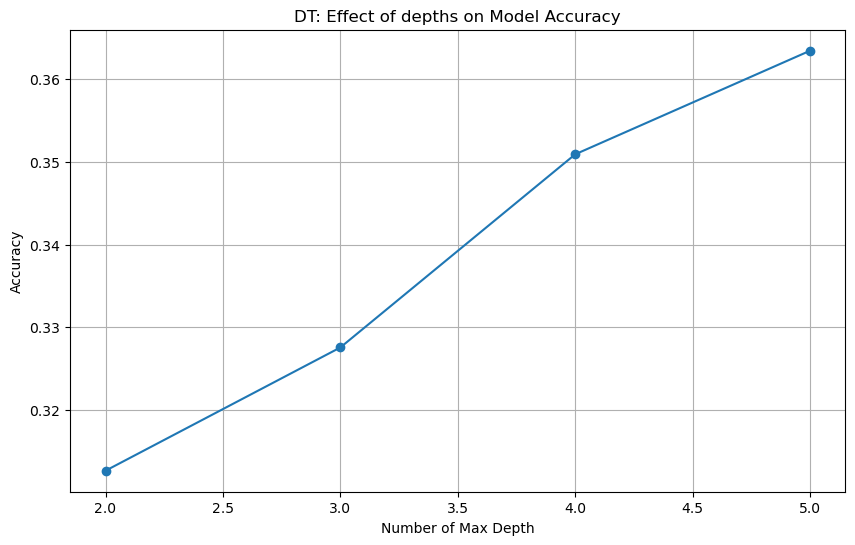

In [17]:
decision_tree()

### Visualize the best performing tree

In [18]:
# Create model
dt_best = DecisionTreeClassifier(max_depth = 5)
dt_best.fit(X_train_scaled, y_train)

# Create the mapping from numeric classes to descriptive names
class_mapping = dict(zip(dt_best.classes_, numeric_features.genre.unique())) 

# convert class labels in dt.classes_ to string using the mapping 
class_names_str = [class_mapping[cls] for cls in dt_best.classes_]

# Plot decision tree
plt.figure(figsize = (12, 15),dpi = 700)
plot_tree(dt_best, feature_names = X.columns, class_names = class_names_str, filled = True, rounded = True)
plt.title("Decision Tree with Max Depth of 5")
plt.savefig('decision_tree.png')